In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from lifelines import KaplanMeierFitter
import scikit_posthocs as posthocs
from datetime import datetime
from dateutil.relativedelta import relativedelta
import scipy.stats as sp
import statistics as st
import os

In [7]:
dimensions = ['contributors', 'commits', "closedPullReqCount", "mergedPullReqCount", "closedIssuesCount", 'stargazerCount', 'forkCount']
acronyms = {'contributors': 'V1', 'commits': 'V2', "closedPullReqCount": 'V3', "mergedPullReqCount": 'V4', "closedIssuesCount": 'V5', 'stargazerCount': 'V6', 'forkCount': 'V7', 'totalSize': 'V8'}

snapshotsFolder = './datasets/snapshots'
monthlyUpdatesFolder = './datasets/updates-monthly-data'
dunnResults = './datasets/dunn-test-results'
varghaResults = './datasets/vargha-test-results'

def folders(freq: str, startDate = "2017-07-01", finishDate = "2023-06-01"):
    months = []
    if freq == 'MS':
        months = pd.date_range(startDate, finishDate, freq="MS")
    if freq == 'AS':
        date = datetime.strptime(startDate, '%Y-%m-%d')
        dateF = datetime.strptime(finishDate, '%Y-%m-%d')
        while date <= dateF:
            months.append(date)
            date = date + relativedelta(years=1)
    folders = []
    for month in months: folders.append(f'{str(month.strftime("%Y-%m-%d"))}')
    return folders

def createCompleteDataset(waves, folder=snapshotsFolder):
    completeDataset = pd.DataFrame()
    for i in range(len(waves)):
        frame = pd.read_csv(f"{folder}/{waves[i]}/frame.csv").copy()
        frame['waves'] = waves[i]
        completeDataset = pd.concat([completeDataset, frame])
    return completeDataset
    
s = folders('AS')
firstWave = pd.read_csv(f"{snapshotsFolder}/{s[0]}/frame.csv")
ALFA = 0.05 / len(dimensions)
CM = 2.54

## RQ1: Temporal validity

#### a) Descriptive statistics and kernel density plots

c:\Users\juancarruthers\Desktop\long_study\longitudinal_study\venv\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\juancarruthers\Desktop\long_study\longitudinal_study\venv\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\juancarruthers\Desktop\long_study\longitudinal_study\venv\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\juancarruthers\Desktop\long_study\longitudinal_study\venv\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\juancarruthers\Desktop\long_study\longitudinal_study\venv\l

SW-pvalue   SW-test    kurtosis  median  skewness  \
contributors              0.0  0.546551   36.338385    61.0  4.999379   
commits                   0.0  0.487665   79.473713  2875.0  6.754429   
closedPullReqCount        0.0  0.399204   67.597556    68.0  7.015058   
mergedPullReqCount        0.0  0.501102   50.303695   325.0  5.547999   
closedIssuesCount         0.0  0.508085   75.661902   472.0  6.634573   
stargazerCount            0.0  0.420744   29.211162   407.0  4.936305   
forkCount                 0.0  0.289873  131.610961   150.0  9.687689   

                    standardDev  
contributors         136.364718  
commits             7131.252460  
closedPullReqCount   362.206649  
mergedPullReqCount  1295.144544  
closedIssuesCount   1426.869167  
stargazerCount      4581.973993  
forkCount           1798.180879

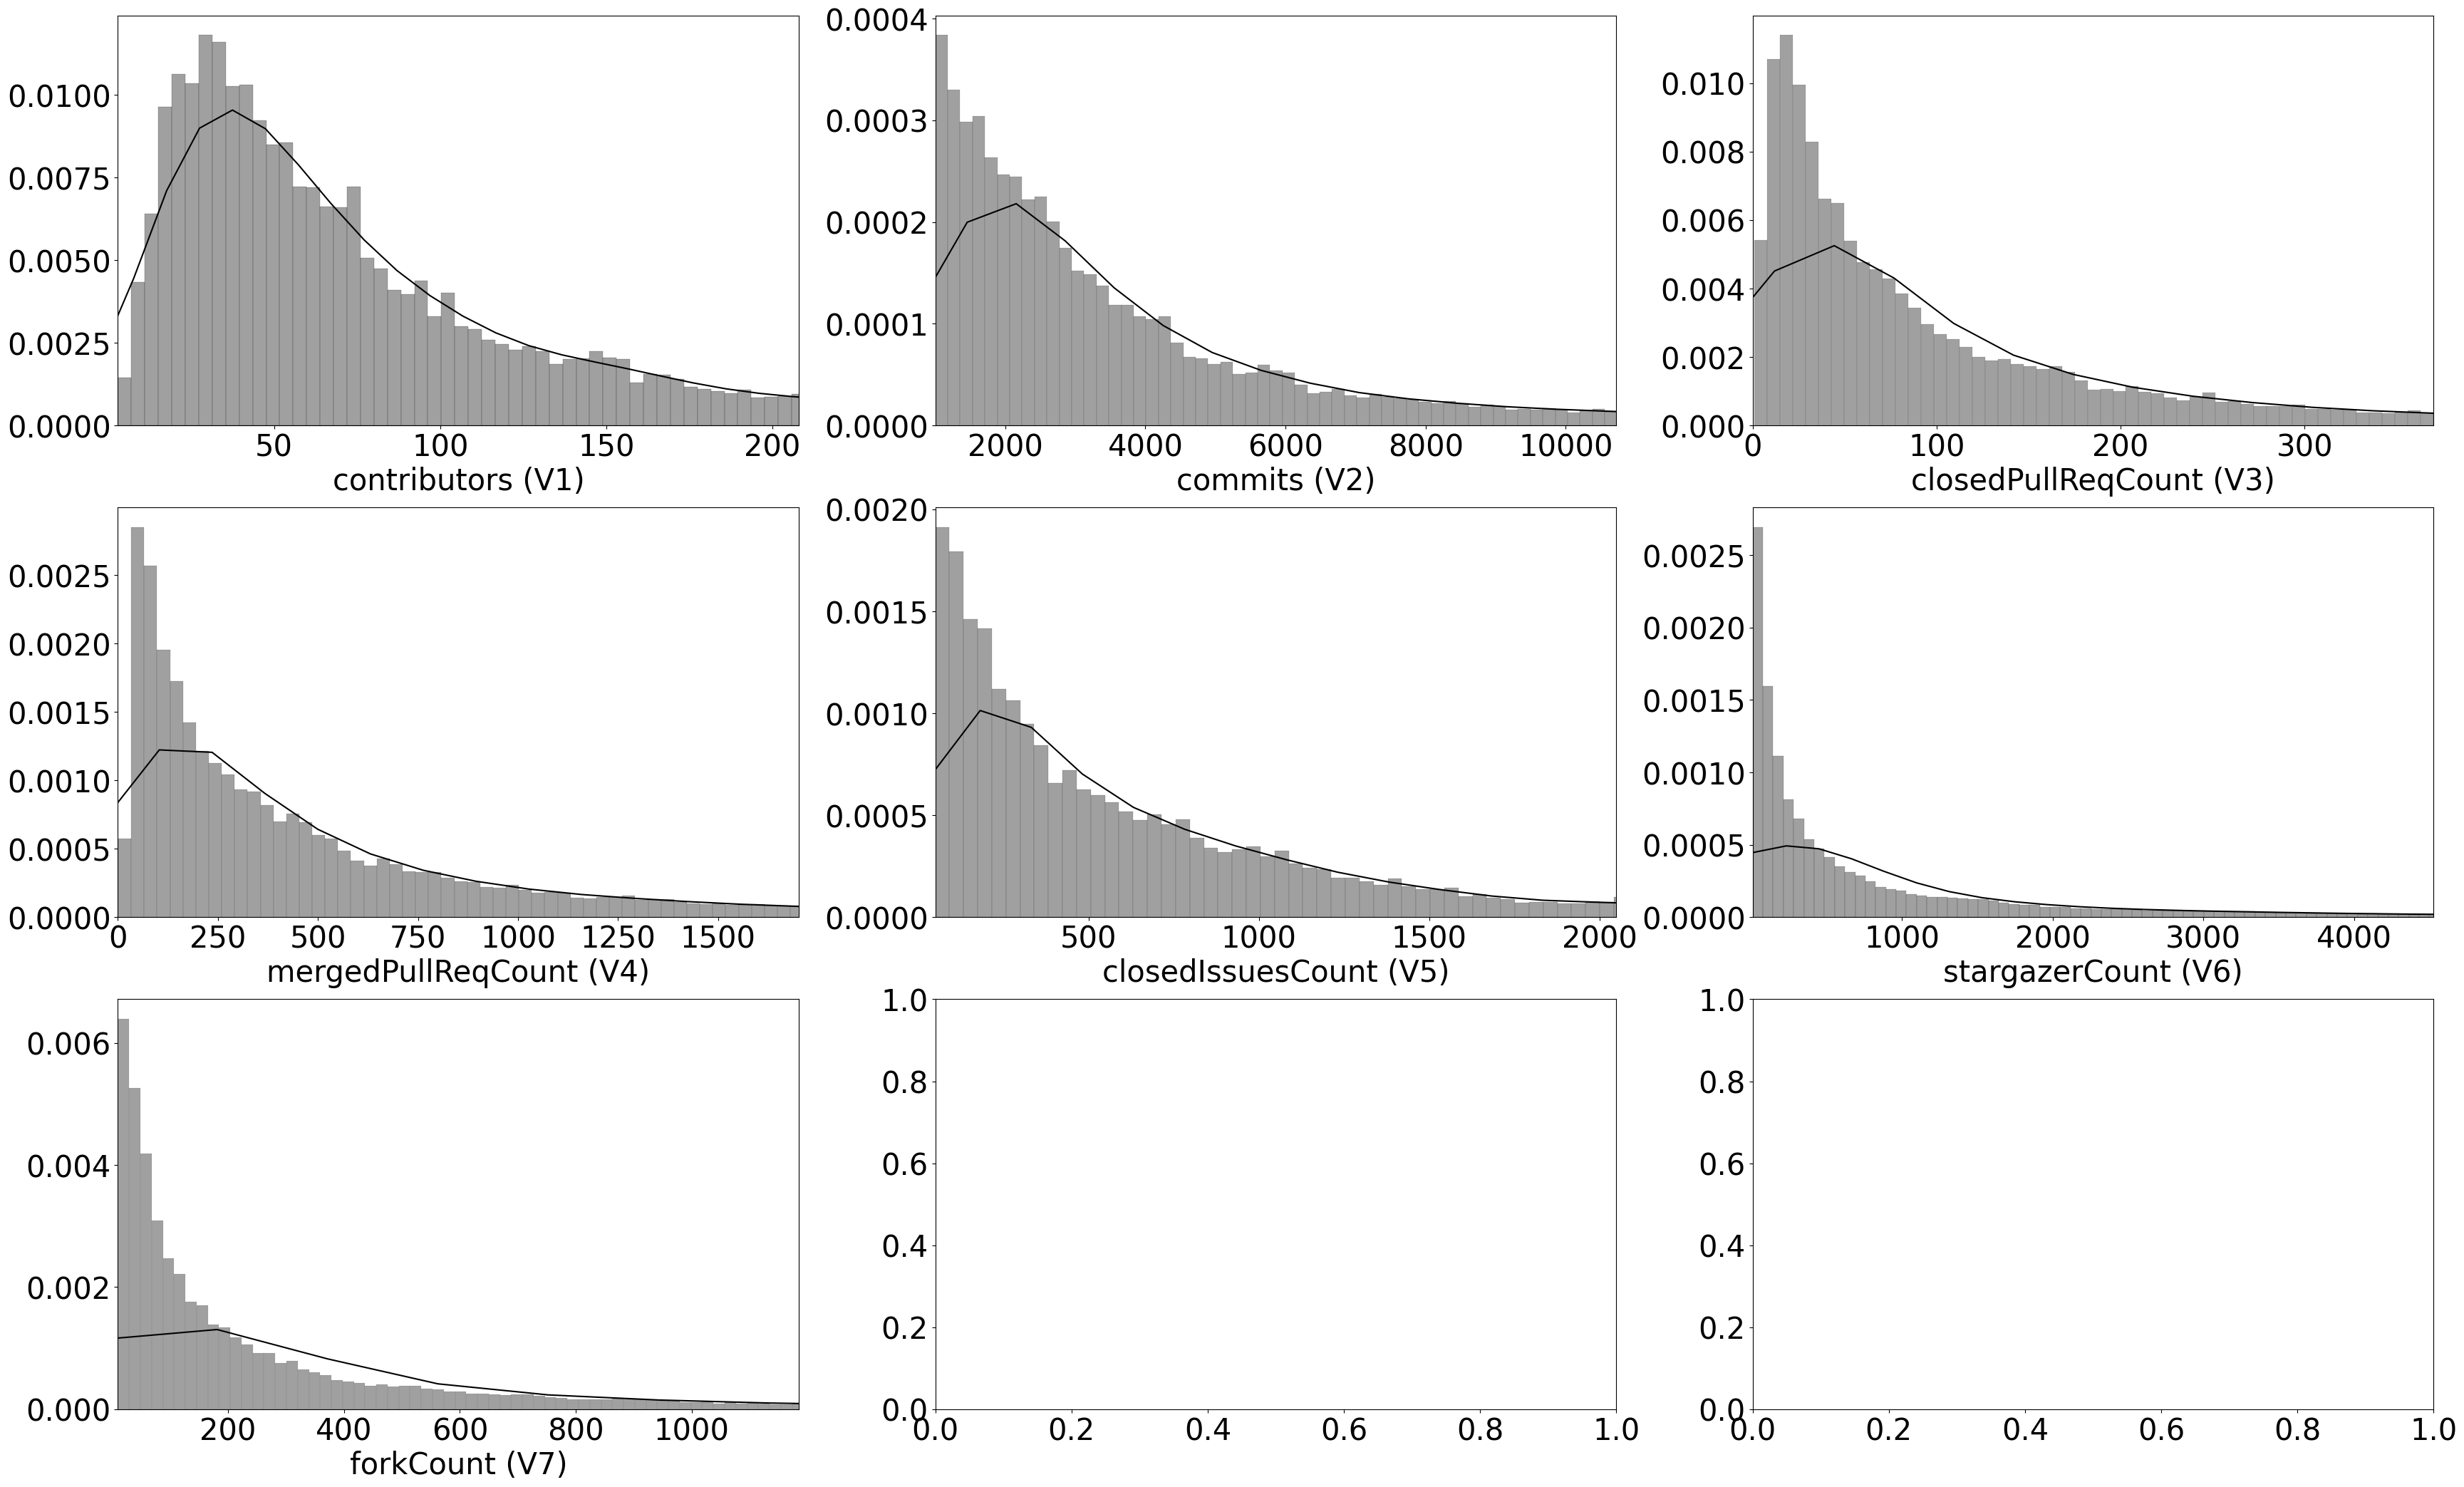

In [8]:
descStats = pd.DataFrame()
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(3, 3, figsize=(16.51*CM, 10*CM))
i = 0
j = 0

completeDataset = createCompleteDataset(folders('MS'))

for dimension in dimensions:
    skewness = sp.skew(completeDataset[dimension], axis=0, bias=True)
    kurtosis = sp.kurtosis(completeDataset[dimension], axis=0, bias=True)
    median = st.median(completeDataset[dimension])
    stDev = st.stdev(completeDataset[dimension])
    shapTest, shapPvalue = sp.shapiro(completeDataset[dimension])
    dimensionStats = {'median': median, 'standardDev': stDev, 'skewness': skewness, 'kurtosis': kurtosis, 'SW-test': shapTest, 'SW-pvalue': shapPvalue}
    descStats = pd.concat([descStats, pd.DataFrame({dimension: dimensionStats})], axis=1)

    plot = completeDataset[completeDataset[dimension] > 0]
    histplot = sns.histplot(data=plot, x=dimension, kde=False, stat='density', color='grey', ax=ax[i,j])
    kdeplot = sns.kdeplot(data=plot, x=dimension, color='black', ax=ax[i,j])
    kdeplot.set(ylabel=None)
    kdeplot.set(xlabel=kdeplot.get_xlabel()+" ("+acronyms[dimension]+")")
    decil = completeDataset[dimension].quantile([0.9]).to_numpy()
    ax[i,j].set_xlim((completeDataset[dimension].min(), decil[0]))



    if j == 2:
        j = 0
        i += 1
    else:
        j += 1

    

descStats.T

#### b) Time Series

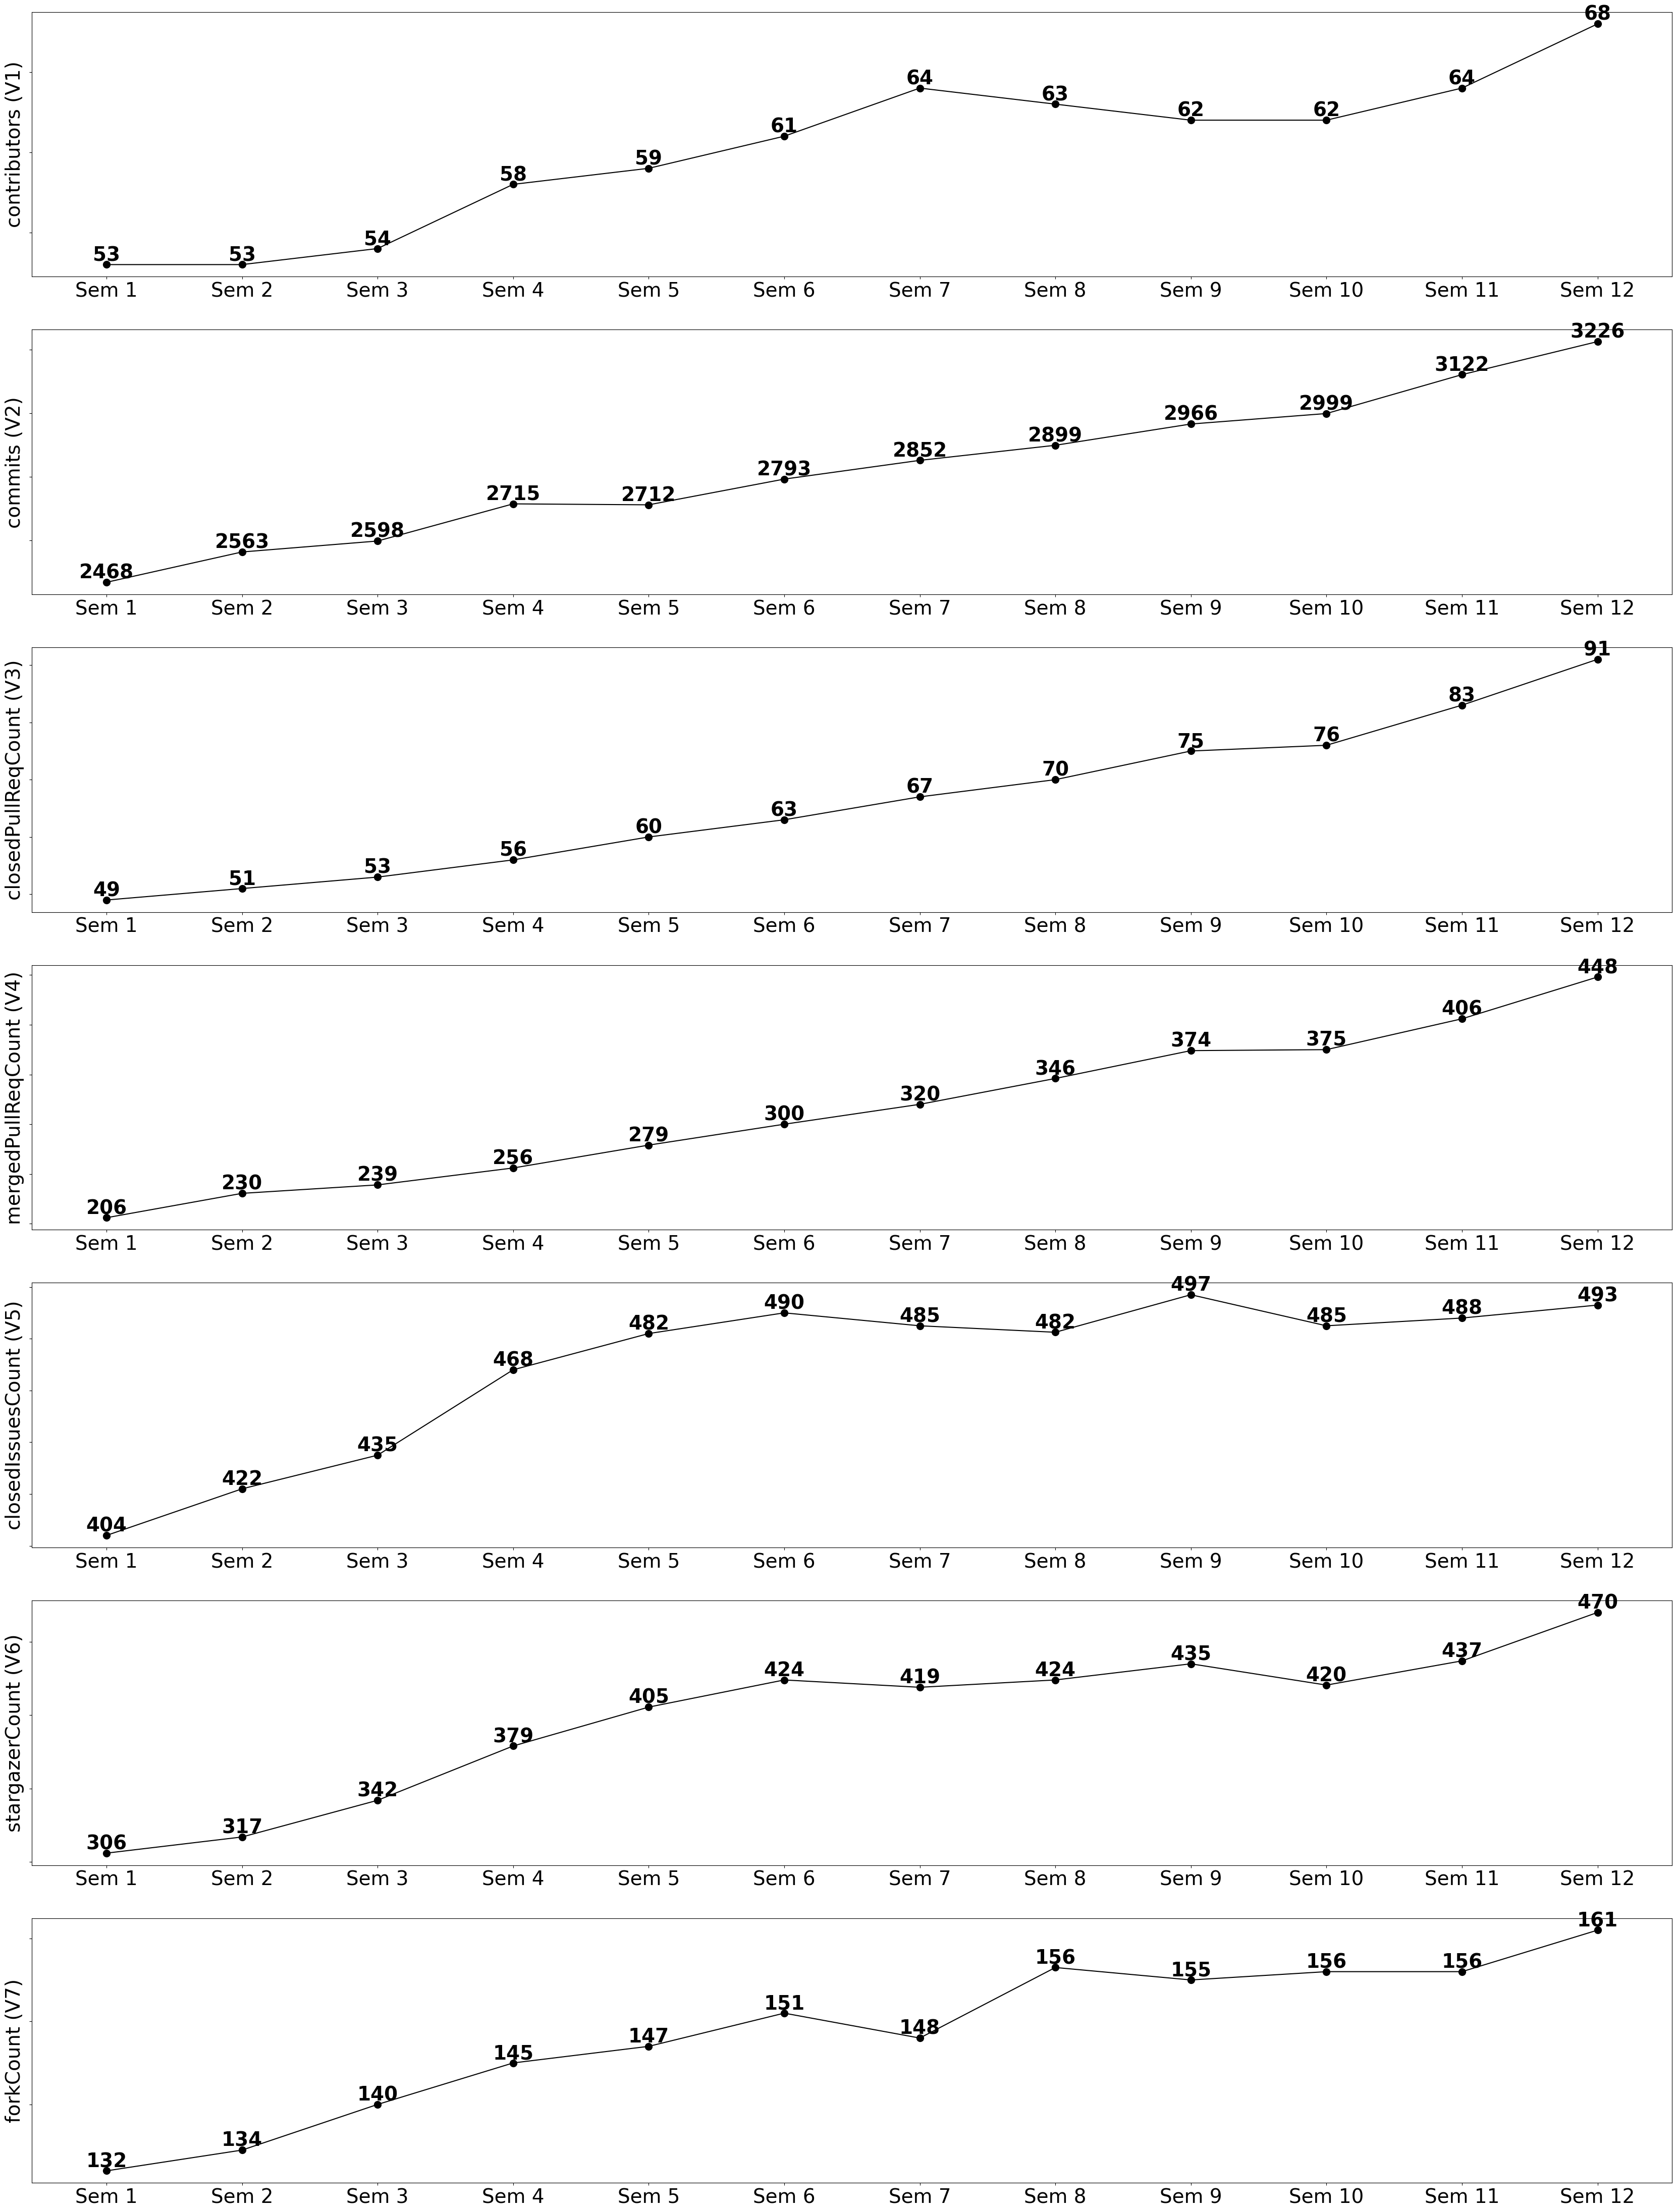

In [9]:
plt.rcParams.update({'font.size': 28})
completeDataset = createCompleteDataset(folders('MS'))

fig, ax = plt.subplots(len(dimensions), 1, figsize=(16.51*CM, 22*CM))


completeDataset['semester'] = 0
months = pd.date_range('2017-07-01', '2023-06-01', freq="MS")
semester = 0
groupedBySemester = pd.DataFrame()
for i in range(len(months)):
    if i % 6 == 0:
        semester += 1 
    completeDataset.loc[completeDataset['waves'] == str(months[i].strftime("%Y-%m-%d")), 'semester'] = semester

groupedBySemester = completeDataset[['semester', *dimensions]].groupby(by='semester').median().copy()
sem = groupedBySemester.index.values
sem = np.char.mod('%d', sem)
sem = np.core.defchararray.add('Sem ', sem)

for i in range(len(dimensions)):
    
    ax[i].plot(sem, groupedBySemester[dimensions[i]].values, marker='o', markersize=10, color='black')
    ax[i].set_ylabel(f"{dimensions[i]} ({acronyms[dimensions[i]]})")
    ax[i].set_yticklabels([])
    
    for j, txt in enumerate(groupedBySemester[dimensions[i]].values):
        ax[i].annotate(int(txt), (sem[j], txt), ha='center', va='bottom', weight='bold')
    
plt.show()

#### c) KW TEST

In [10]:
for dimension in dimensions:
    datasetGrouped = completeDataset.groupby('waves')[dimension].apply(list).values
    kwTest, kwPvalue = sp.kruskal(*datasetGrouped)
    print (f'{dimension}: -p-value:{kwPvalue} - Test: {kwTest}')

contributors: -p-value:3.0843323107302293e-45 - Test: 388.1716244489817
commits: -p-value:7.153662258552381e-47 - Test: 397.29210025850796
closedPullReqCount: -p-value:7.816610139721793e-238 - Test: 1361.4077926374046
mergedPullReqCount: -p-value:2.331723205369195e-309 - Test: 1706.3557600074525
closedIssuesCount: -p-value:9.32349763548978e-13 - Test: 189.67984092005716
stargazerCount: -p-value:3.788508619554975e-12 - Test: 185.2838194021179
forkCount: -p-value:0.0001566889744896636 - Test: 122.1033518534635


#### d) DUNN & VARGHA TESTS

In [11]:
def varghaDelaney(a, b):
    m = len(a)
    n = len(b)
    U = sp.rankdata(np.concatenate([a, b]))
    R1 = U[:m].sum()
    R2 = U[m:].sum()
    v = (R1/m - (m+1)/2)/n
    return v

if not (os.path.isdir(dunnResults)):
    os.mkdir(dunnResults)
if not (os.path.isdir(varghaResults)):
    os.mkdir(varghaResults)

plt.rcParams.update({'font.size': 30})
waves = folders('MS')
completeDataset = createCompleteDataset(waves)
completeDatasetNewIndex = completeDataset.reset_index().copy()
graphicsList = []
kwRes = pd.DataFrame()

for dimension in dimensions:
    datasetGrouped = completeDataset.groupby('waves')[dimension].apply(list).values
    dunn = posthocs.posthoc_dunn(datasetGrouped)
    kwTest, kwPvalue = sp.kruskal(*datasetGrouped)
    result = pd.DataFrame({'Variable': [dimension], 'KW-Test': [kwTest], 'KW-Pvalue': [kwPvalue]})
    kwRes = pd.concat([kwRes, result])
    
    if kwPvalue < ALFA:
        dunn.to_csv(f'{dunnResults}/{dimension}.csv') 
        values = dunn.values < ALFA 
        dunn[dunn < 1] = 0
        for i in range(dunn.shape[0]):          
            indexes =  np.where(values[i,:])[0].tolist()     
            for j in indexes:
                a = completeDataset[completeDataset['waves'] == waves[i]][dimension].values
                b = completeDataset[completeDataset['waves'] == waves[j]][dimension].values
                vg = varghaDelaney(a, b)
                dunn.loc[i+1, j+1] = (vg-0.5)*2         
        dunn.to_csv(f'{varghaResults}/{dimension}.csv')    
    


## RQ2: Data Shifts

#### a) GENERAL

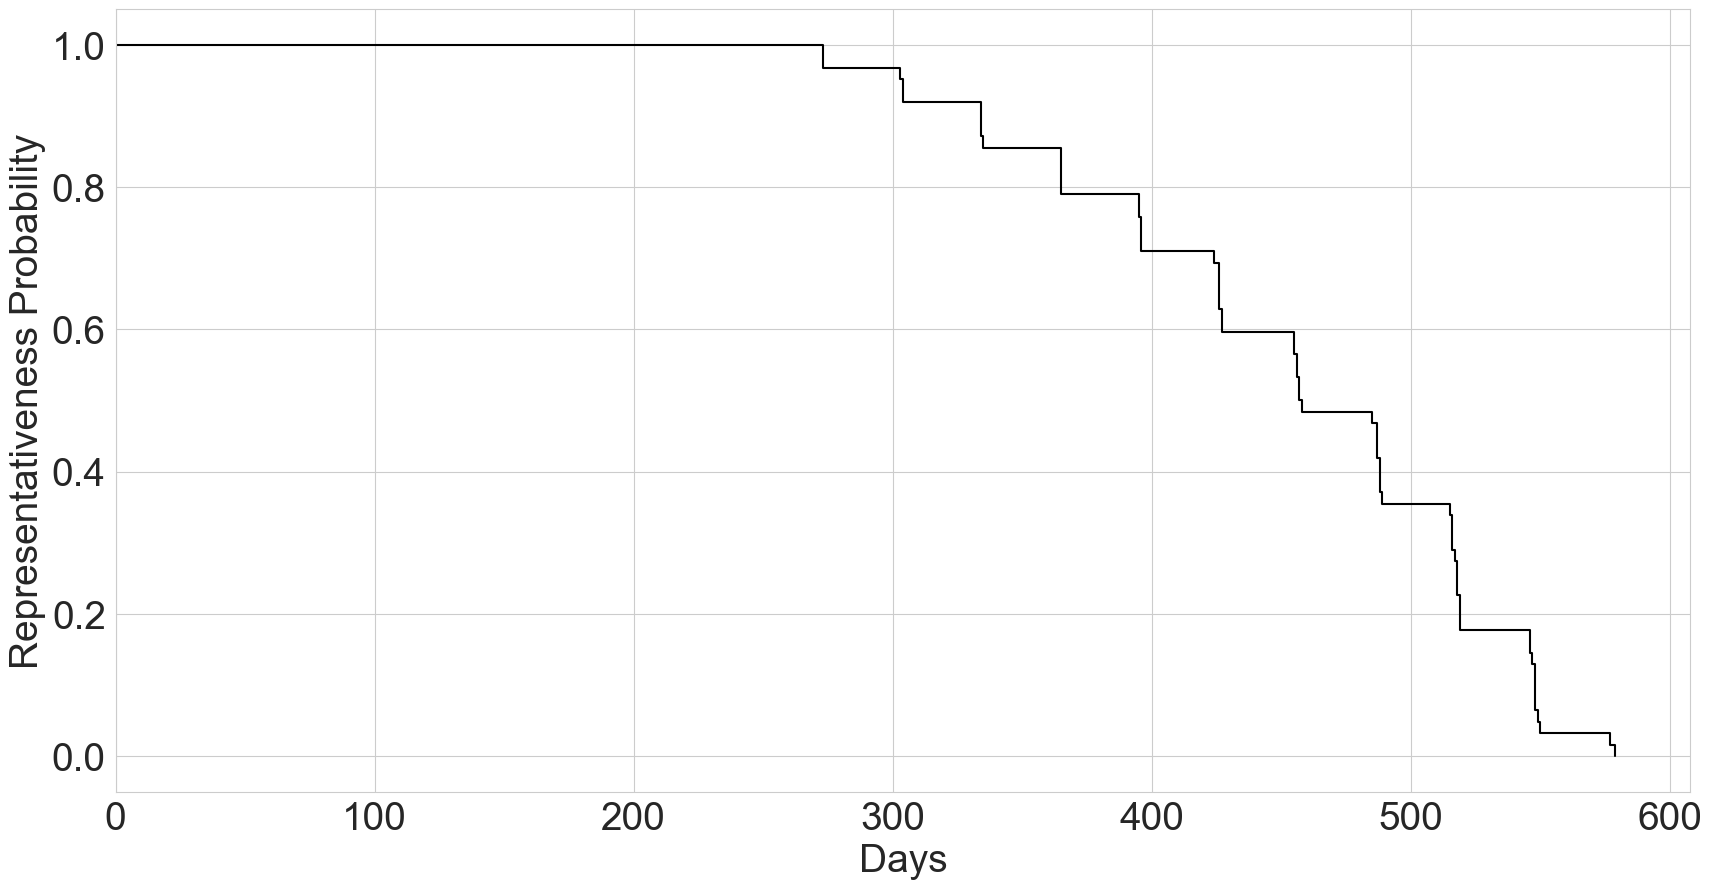

In [17]:
time = []
events = []
waves = folders('MS')

for i in range(len(waves)):
    aframe = pd.read_csv(f"{snapshotsFolder}/{waves[i]}/frame.csv").copy()
    for j in range(i, len(waves)):   
        flag = False  
        bframe = pd.read_csv(f"{snapshotsFolder}/{waves[j]}/frame.csv").copy()
        for dimension in dimensions:
            mw = sp.mannwhitneyu(aframe[dimension], bframe[dimension])
            if mw[1] < ALFA:
                events.append(1)
                adate = datetime.strptime(waves[i], "%Y-%m-%d")
                bdate = datetime.strptime(waves[j], "%Y-%m-%d")
                difference = (bdate - adate).days
                time.append(difference)
                flag = True
                break
        if flag:
            break
    if not flag:
        events.append(0)
        adate = datetime.strptime(waves[i], "%Y-%m-%d")
        bdate = datetime.strptime(waves[j], "%Y-%m-%d")
        difference = (bdate - adate).days
        time.append(difference)


sdata = pd.DataFrame({'waves': waves, 'time': time, 'event': events})

kmf = KaplanMeierFitter()
kmf.fit(sdata['time'], event_observed=sdata['event'])

plt.figure(figsize=(8*CM,4*CM))
plt.step(kmf.survival_function_.index, kmf.survival_function_['KM_estimate'], where='post', label=dimension, color='black')

plt.xlim(left=0)

plt.xlabel('Days')
plt.ylabel('Representativeness Probability')
plt.show()

#### b) DIMENSION SPECIFIC

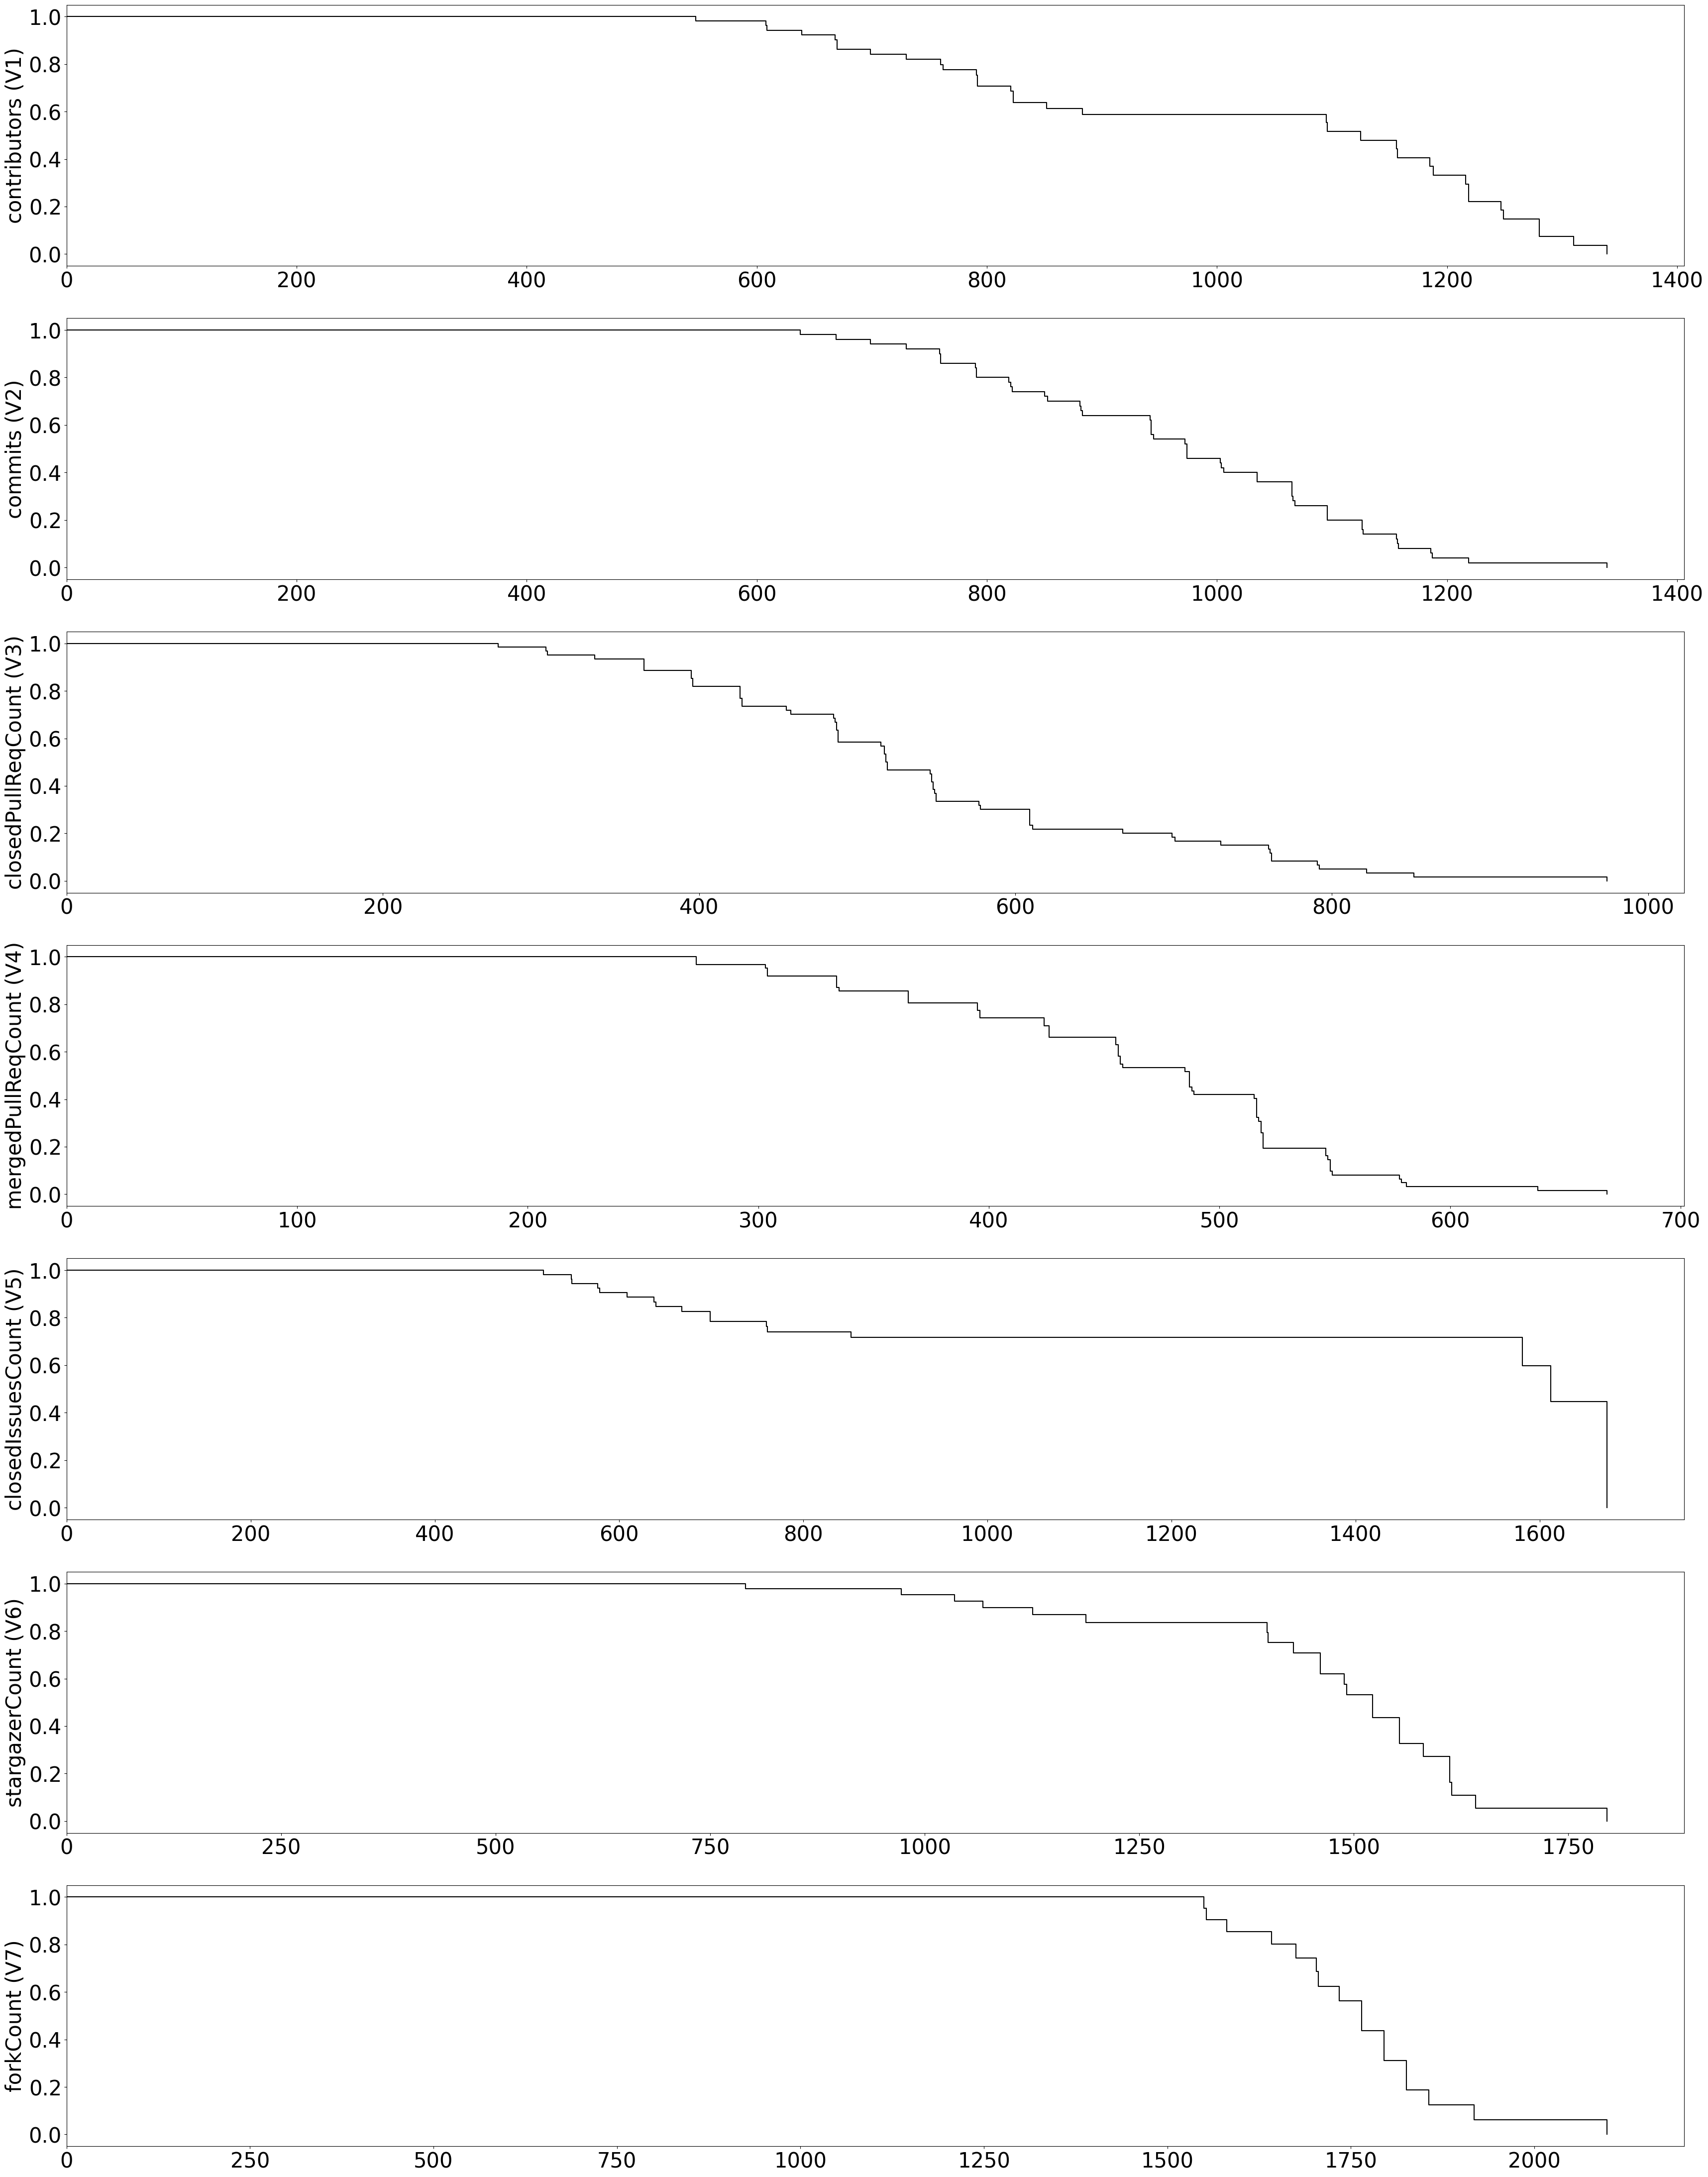

In [13]:

time = []
events = []
waves = folders('MS')

fig, ax = plt.subplots(len(dimensions), 1, figsize=(16.51*CM, 22*CM))
k = 0

for dimension in dimensions:
    for i in range(len(waves)):
        aframe = pd.read_csv(f"{snapshotsFolder}/{waves[i]}/frame.csv").copy()
        for j in range(i, len(waves)):   
            flag = False  
            bframe = pd.read_csv(f"{snapshotsFolder}/{waves[j]}/frame.csv").copy()
            
            mw = sp.mannwhitneyu(aframe[dimension], bframe[dimension])
            if mw[1] < ALFA:
                events.append(1)
                adate = datetime.strptime(waves[i], "%Y-%m-%d")
                bdate = datetime.strptime(waves[j], "%Y-%m-%d")
                difference = (bdate - adate).days
                time.append(difference)
                flag = True
                break
        if not flag:
            events.append(0)
            adate = datetime.strptime(waves[i], "%Y-%m-%d")
            bdate = datetime.strptime(waves[j], "%Y-%m-%d")
            difference = (bdate - adate).days
            time.append(difference)
        
    
    sdata = pd.DataFrame({'waves': waves, 'time': time, 'event': events})
    kmf = KaplanMeierFitter()
    kmf.fit(sdata['time'], event_observed=sdata['event'])

    ax[k].step(kmf.survival_function_.index, kmf.survival_function_['KM_estimate'], where='post', label=dimension, color='black')
    ax[k].set(ylabel=f'{dimension} ({acronyms[dimension]})')
    ax[k].set_xlim(xmin=0)
    k += 1
    time = []
    events = []

plt.show()

## RQ3: Update frequency

#### a) REPRESENTATIVENESS SURVIVAL CURVES

C:\Users\juancarruthers\AppData\Local\Temp\ipykernel_16116\2082331883.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waveLastActivity['waveCounter'] = waveCounter
C:\Users\juancarruthers\AppData\Local\Temp\ipykernel_16116\2082331883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waveLastActivity['event'] = event
C:\Users\juancarruthers\AppData\Local\Temp\ipykernel_16116\2082331883.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

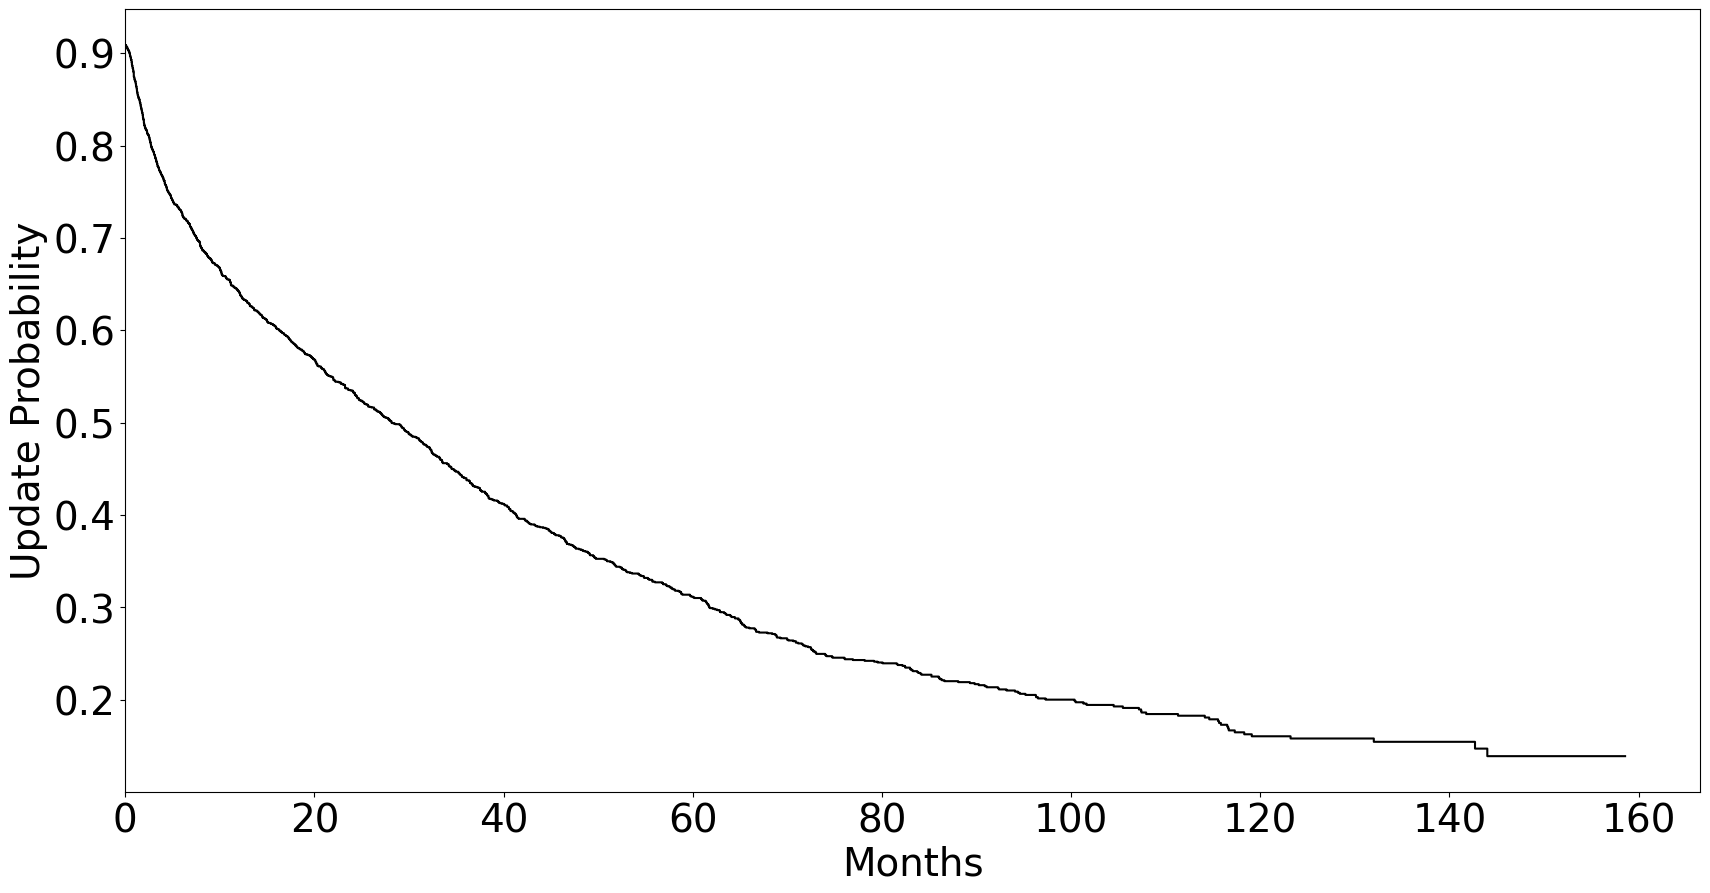

In [14]:
fmt = '%Y-%m-%d  %H:%M:%S'
historicData = createCompleteDataset(folders('MS', startDate="2009-01-01"), monthlyUpdatesFolder).sort_values(by=['id', 'waves'])
allProjects = historicData.drop_duplicates('id')
historicData['dateLastCommit'] = pd.to_datetime(historicData['dateLastCommit'], format=fmt)
historicData['mergedPullReqLastDate'] = pd.to_datetime(historicData['mergedPullReqLastDate'], format=fmt)
historicData['closedPullReqLastDate'] = pd.to_datetime(historicData['closedPullReqLastDate'], format=fmt)
historicData['lastActivity'] = historicData[['dateLastCommit', 'closedPullReqLastDate', 'mergedPullReqLastDate']].max(axis=1)

times = []
events = []
boxplot = pd.DataFrame()

for id, project in allProjects.iterrows():
    projectHistoric = historicData[historicData['id'] == project['id']]
    waveLastActivity = pd.DataFrame(projectHistoric.iloc[0]).T
    firstActivity = waveLastActivity.iloc[0]['lastActivity']
    lastActivity = firstActivity
    event = 0
    waves = folders('MS', startDate=waveLastActivity.iloc[0]['waves'])
    waveCounter = 0
    
    for wave in waves[1:]:
        waveActivity = projectHistoric[projectHistoric['waves'] == wave]
        
        if not waveActivity.empty:
            waveLastActivity = waveActivity
            waveCounter += 1
            lastActivity = waveActivity.iloc[0]['lastActivity']
        else:
            event = 1
            break
    
    duration = (lastActivity - firstActivity).days
    times.append(duration/30)
    events.append(event)
    waveLastActivity['waveCounter'] = waveCounter
    waveLastActivity['event'] = event
    waveLastActivity['duration'] = duration
    boxplot = pd.concat([boxplot, waveLastActivity])


kmf3 = KaplanMeierFitter()
kmf3.fit(times, events)

plt.rcParams.update({'font.size': 28})
plt.figure(figsize=(8*CM,4*CM))
plt.step(kmf3.survival_function_.index, kmf3.survival_function_['KM_estimate'], where='post', color='black')
plt.xlabel('Months')
plt.ylabel('Update Probability')
plt.xlim(left=0)
plt.show()


#### b) Q1 AND Q4 BOXPLOTS

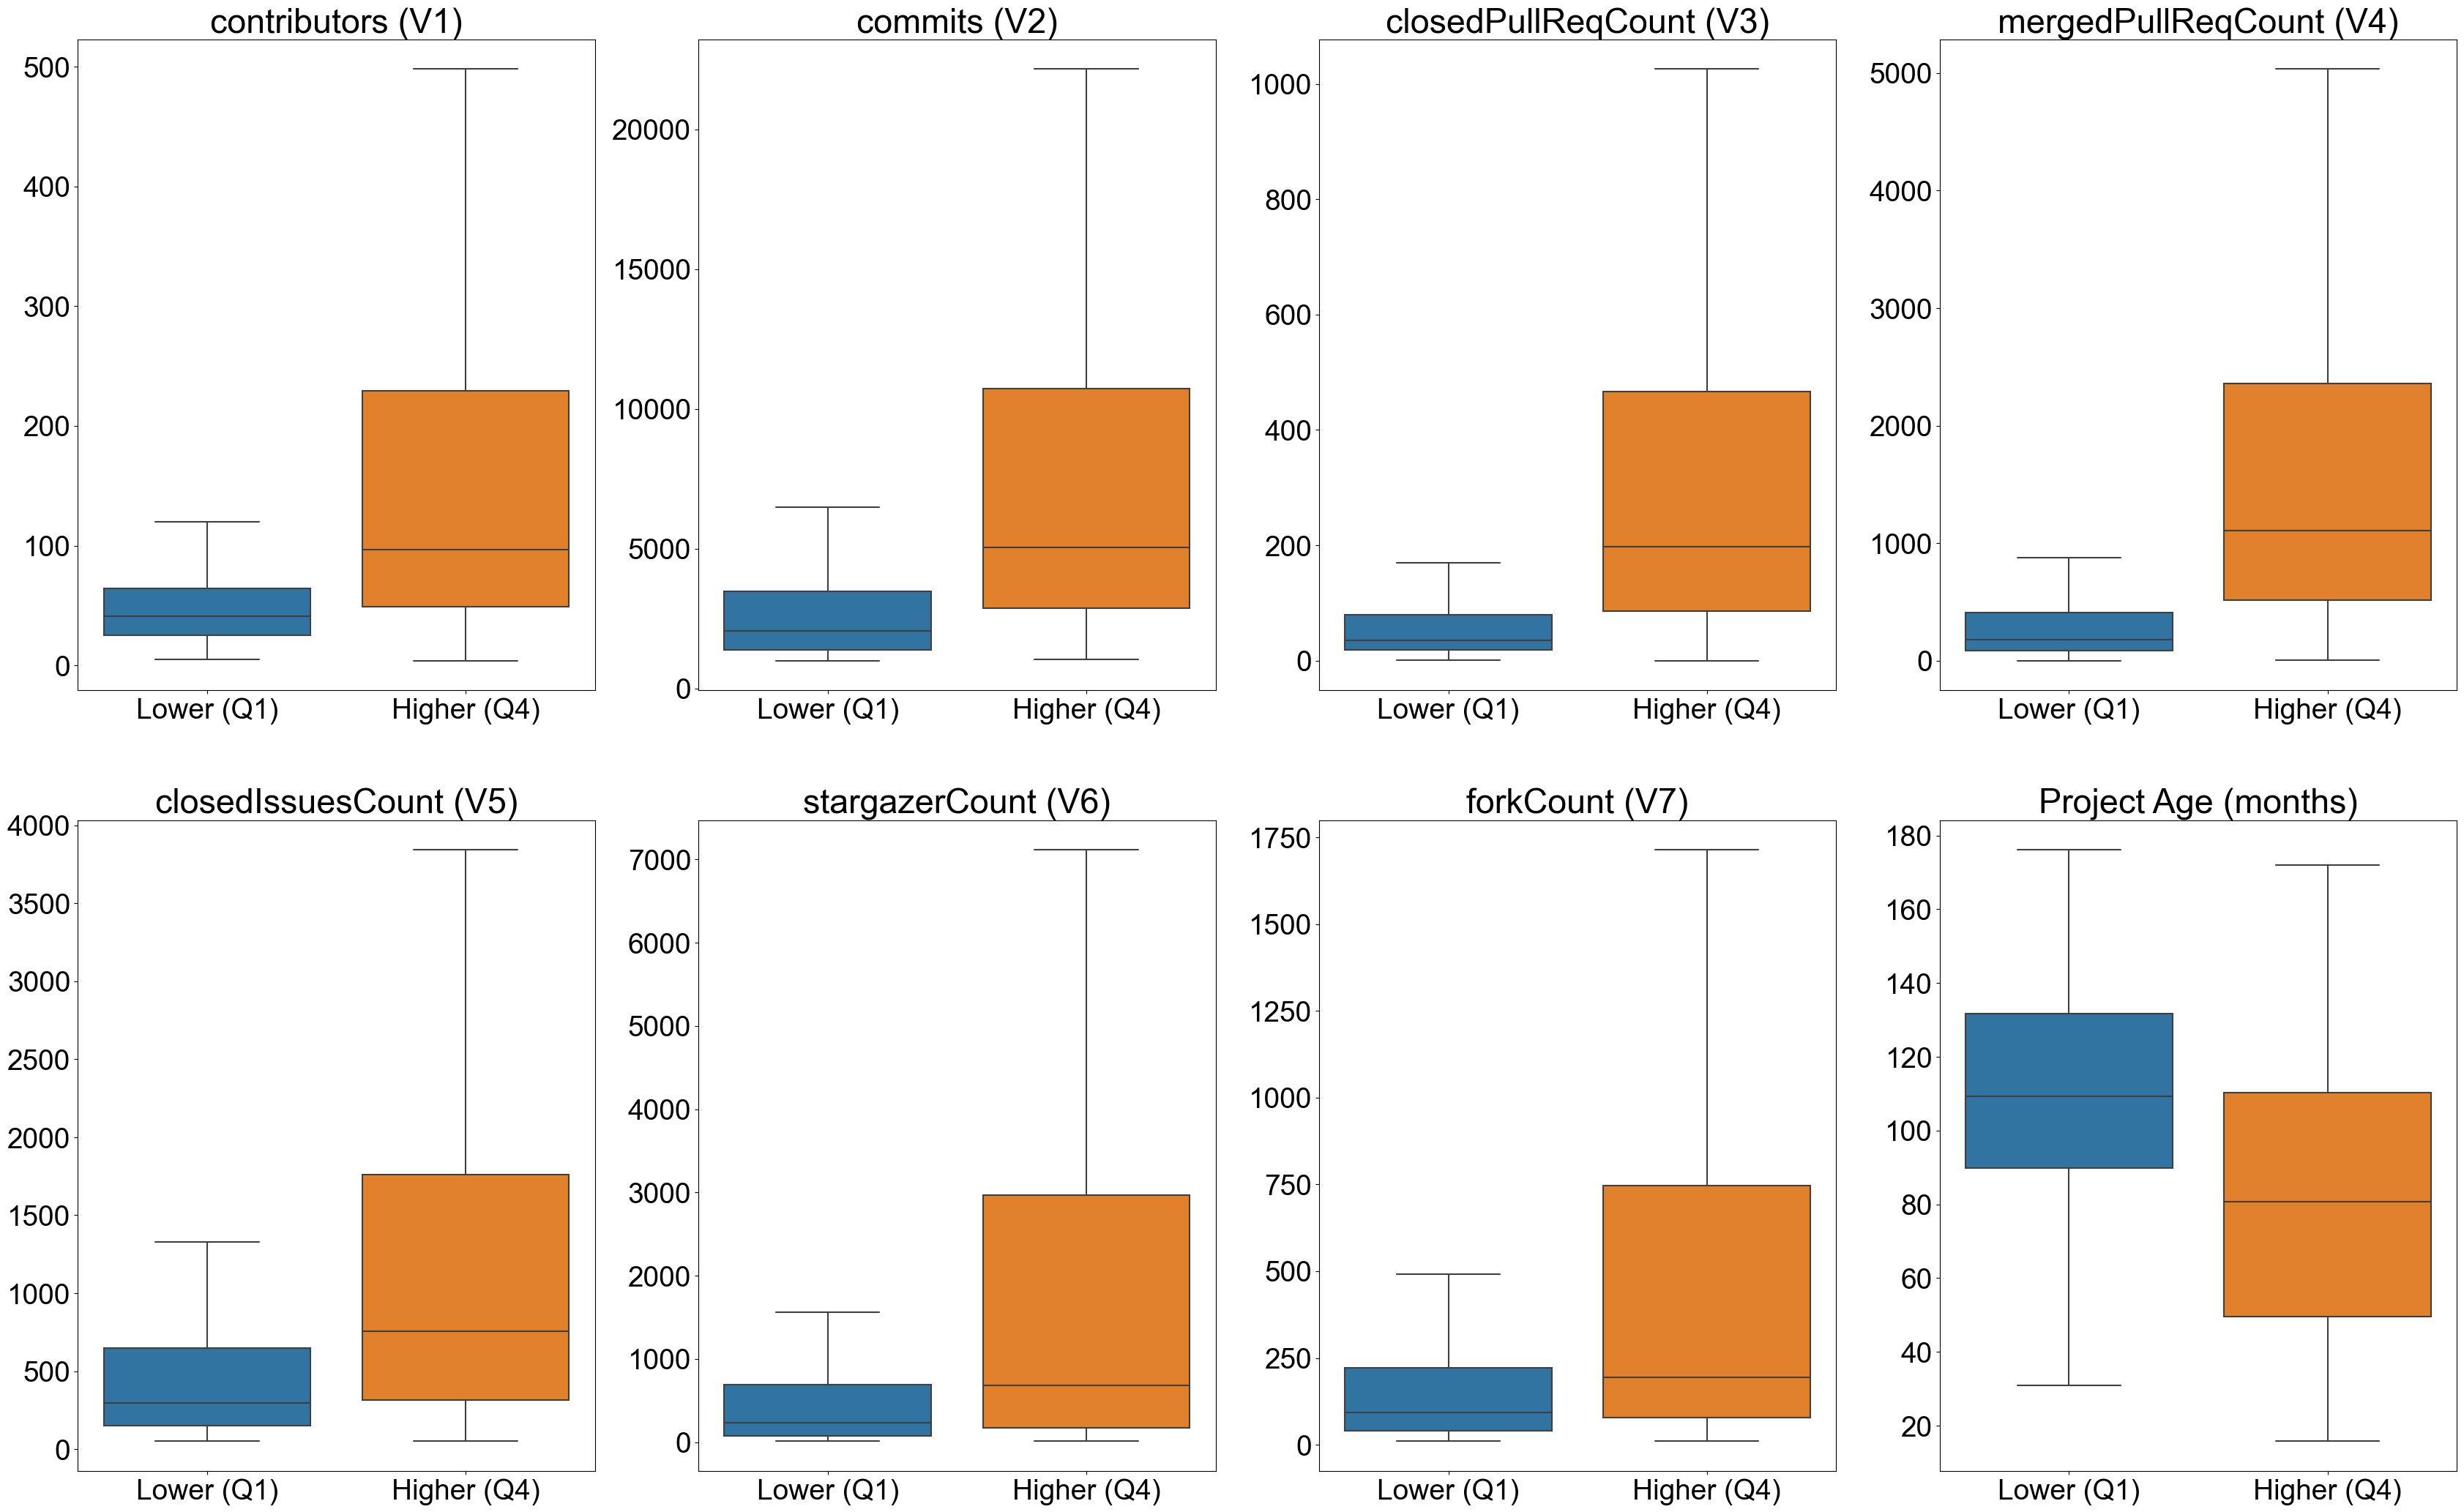

In [15]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(2, 4, figsize=(16.51*CM, 10*CM))

PROPS = {
    'flierprops':{"marker": "o", 'markeredgecolor': 'black', 'markerfacecolor': 'white'},
    'showfliers': False
}
sns.set_style('whitegrid')

months = folders('MS')
completeDataset = createCompleteDataset(months, monthlyUpdatesFolder)
allProjects = completeDataset.sort_values(['id', 'waves'], ascending=False).drop_duplicates('id')
completeDataset['waves'] = pd.to_datetime(completeDataset['waves'], format='%Y-%m-%d')
aYearAgo = '2022-07-01'
completeDataset = completeDataset[completeDataset['waves'] >= datetime.strptime(aYearAgo, '%Y-%m-%d')]
completeDataset = completeDataset[['id', 'monthlyclosedPullReq', 'monthlyCommits', 'monthlymergedPullReq']]

for id, project in allProjects.iterrows():
    lastYear = folders('MS', aYearAgo)
    emptyMonths = len(lastYear) - completeDataset[completeDataset['id'] == project['id']].shape[0]
    emptyRows = pd.DataFrame(np.repeat([[project['id'], 0, 0, 0]] , emptyMonths, axis=0))
    emptyRows.columns = completeDataset.columns
    completeDataset = pd.concat([completeDataset, emptyRows])

completeDataset['monthlyclosedPullReq'] = pd.to_numeric(completeDataset['monthlyclosedPullReq'])
completeDataset['monthlyCommits'] = pd.to_numeric(completeDataset['monthlyCommits'])
completeDataset['monthlymergedPullReq'] = pd.to_numeric(completeDataset['monthlymergedPullReq'])
completeDataset = completeDataset.sort_values('id')

aux = completeDataset.groupby(['id']).mean()
aux['updates'] = aux[['monthlyclosedPullReq', 'monthlyCommits', 'monthlymergedPullReq']].sum(axis='columns')
allProjects = allProjects.sort_values('id')
allProjects['updates'] = aux['updates'].values

quantiles = allProjects['updates'].quantile([0.25, 0.5, 0.75]).to_numpy()
quartiles = pd.concat([allProjects[allProjects['updates'] < quantiles[0]], allProjects[allProjects['updates'] >= quantiles[2]]])
quartiles['updateProneness'] = quartiles['updates'] >= quantiles[1]
quartiles['createdAt'] = pd.to_datetime(quartiles['createdAt'], format=fmt)
quartiles['months'] = datetime.now()
quartiles['months'] = (quartiles['months'] - quartiles['createdAt']).dt.days / 30

j = 0
k = 0

for i in range(len(dimensions)):
    
    boxplotGraph = sns.boxplot(x='updateProneness', y=dimensions[i], data=quartiles, ax=ax[j,k], **PROPS)
    boxplotGraph.set(title=boxplotGraph.get_ylabel()+" ("+acronyms[dimensions[i]]+")")
    boxplotGraph.set(xlabel = None, ylabel = None)  
    ax[j,k].set_xticklabels(["Lower (Q1)","Higher (Q4)"])
    
    if k==3:
        j += 1
        k = 0
    else:   
        k += 1


boxplotGraph = sns.boxplot(x='updateProneness', y='months', data=quartiles, ax=ax[j,k], **PROPS)
boxplotGraph.set(title=f"Project Age (months)")
boxplotGraph.set(xlabel = None, ylabel = None)  
ax[j,k].set_xticklabels(["Lower (Q1)","Higher (Q4)"])

plt.show()

In [16]:
inactiveProjects = boxplot[boxplot['event'] == 1].copy()
inactiveProjects['duration'] = pd.to_numeric(inactiveProjects['duration'])
i = 1
YEAR = 365
yearlyInactivity = pd.DataFrame(columns=['Years', 'ProjQ'])
while (not inactiveProjects.empty):
    yearlyInactiveProjects = inactiveProjects[(inactiveProjects['duration'] >= (i-1)*YEAR) & (inactiveProjects['duration'] <= i*YEAR)]
    year = pd.DataFrame({'Years': [i], 'ProjQ': [yearlyInactiveProjects.shape[0]]})
    inactiveProjects = inactiveProjects[~inactiveProjects['id'].isin(yearlyInactiveProjects['id'])]
    yearlyInactivity = pd.concat([yearlyInactivity, year])
    i += 1

yearlyInactivity


Years ProjQ
0     1   671
0     2   198
0     3   167
0     4   122
0     5    74
0     6    78
0     7    26
0     8    24
0     9    10
0    10    12
0    11     2
0    12     2